# Fall 2022 Data Science Intern Challenge


## Question 1

Given some sample data, write a program to answer the following: [click here to access the required data set](https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0)

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

### Preliminary Work

In [1]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's check the data first

In [2]:
# load the data
data = pd.read_csv("2019 Winter Data Science Intern Challenge Data Set.csv")
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [3]:
# Check missing values
print(data.isnull().sum())

# check any duplicate rows
print(data.duplicated().sum())

order_id          0
shop_id           0
user_id           0
order_amount      0
total_items       0
payment_method    0
created_at        0
dtype: int64
0


No missing value and duplicate rows are found!

In [4]:
# check any duplicate rows
data.duplicated().sum()

0

### a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

**Short Answer**: The way that AOV is calculated is wrong. Also, there are some anomalies in the dataset which we need to remove first (store 42 and 78). The new AOV is about 152 which makes sense.

According to the [Shopify blog](https://www.shopify.ca/blog/average-order-value) AOV is the average order value and can be calculated simply by dividing total revenue by the number of orders. The naively calculated AOV ($3145.13) is the average of all the "order_amount" data without considering the "total_item" which is not correct.

In [5]:
print("naively calculate AOV = ", data['order_amount'].mean())

naively calculate AOV =  3145.128


To correct this, we can consider two methods. First, calculate the AOV per shop and then take the average. Second, calculate AOV for all sneaker shops by dividing total revenue by the total number of orders in all rows.

In [6]:
# first method
total_revenue_by_shopid = data.groupby(['shop_id'])['order_amount'].agg('sum')
total_orders_by_shopid = data.groupby(['shop_id'])['total_items'].agg('sum')
aov_by_shopid = total_revenue_by_shopid/total_orders_by_shopid 
aov_by_shopid.name = 'aov'
data_by_shopid = pd.concat([aov_by_shopid], axis=1)
data_by_shopid

,aov
shop_id,
1,158.0
2,94.0
3,148.0
4,128.0
5,142.0
...,...
96,153.0
97,162.0
98,133.0


In [7]:
data_by_shopid.describe()

,aov
count,100.000000
mean,407.990000
std,2557.462906
min,90.000000
25%,132.750000
50%,153.000000
75%,168.250000
max,25725.000000


In [8]:
# or
print("AOV for method 1:", data_by_shopid.mean()[0])

AOV for method 1: 407.99


In [9]:
# second method
total_revenue = data['order_amount'].sum()
total_orders = data['total_items'].sum()
print("AOV for method 2:", total_revenue/total_orders)

AOV for method 2: 357.92152221412965


Although the AOV becomes 407.99 and 357.92 for two methods, it is still a high price for a relatively affordable sneaker. So we need further analysis to find the anomalies.

To do the analysis, I added the new column called aov_per_transaction which is "order_amount" divided by "total_items". In this way, I can find all the anomalies per row or transaction. (The other way can be finding anomalies per store instead of per transaction. However, this method could remove all data for a store if only one of the transactions is an anomaly. So finding anomalies per transaction is much more robust and can keep more beneficial data in our dataset.)

In [10]:
data['aov_per_transaction'] = data['order_amount'] / data['total_items']
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,aov_per_transaction
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
2,3,44,861,144,1,cash,2017-03-14 4:23:56,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,156.0


In [11]:
data['aov_per_transaction'].describe()

count     5000.000000
mean       387.742800
std       2441.963725
min         90.000000
25%        133.000000
50%        153.000000
75%        169.000000
max      25725.000000
Name: aov_per_transaction, dtype: float64

However, the very high standard deviation compared to the mean does not make sense. So, we can say that our data may have outliers. I also visualize the histogram for this column.

<AxesSubplot:>

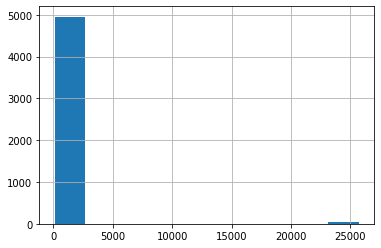

In [12]:
data['aov_per_transaction'].hist()

As we can see in the diagram there are some transactions with AOV around 25000$ which doesn't make sense. Let's remove them:

In [13]:
data_no_outlier = data[data['aov_per_transaction']<5000]

Let's find out which stores have these abnormal AOV values:

In [14]:
# find stores that have outlier:
index = data.index[data['aov_per_transaction']>5000].tolist()
print("store {} has outliers.".format(data['shop_id'][index].unique()[0]))

store 78 has outliers.


Let's check the new data:

In [15]:
data_no_outlier['aov_per_transaction'].describe()

count    4954.000000
mean      152.475575
std        31.260218
min        90.000000
25%       132.000000
50%       153.000000
75%       168.000000
max       352.000000
Name: aov_per_transaction, dtype: float64

<AxesSubplot:>

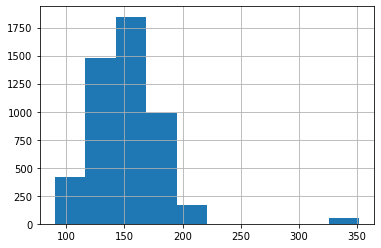

In [16]:
data_no_outlier['aov_per_transaction'].hist()

As you can see in the diagram, there are some transactions around 350$. We may consider them as outliers or we may keep them since this amount for sneakers may not consider too high. For example, some stores may have limited higher quality sneakers at this price. Let's see which stores are selling these sneakers:

In [17]:
# find stores that have outlier:
index = data.index[data['aov_per_transaction']>300].tolist()
print("store {} has outliers.".format(data['shop_id'][index].unique()))

store [42 78] has outliers.


So, we may remove these transactions from store 32 as outliers as well.

In [18]:
data_no_outlier2 = data[data['aov_per_transaction']<300]
data_no_outlier2['aov_per_transaction'].describe()

count    4903.000000
mean      150.400163
std        23.851202
min        90.000000
25%       132.000000
50%       153.000000
75%       166.000000
max       201.000000
Name: aov_per_transaction, dtype: float64

<AxesSubplot:>

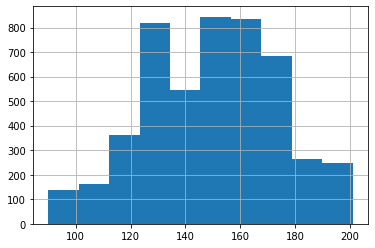

In [19]:
data_no_outlier2['aov_per_transaction'].hist()

### b. What metric would I report for this dataset?

AOV, median, and mode are common metrics. Note that the median is a great choice for a dataset with outliers since it is a good indicator of the center of the ordered dataset and it can reduce the effect of outliers.

### c. What is its value?

Median is 153$.

In [20]:
print("Mean AOV:",data_no_outlier['aov_per_transaction'].mean())
print("Median AOV:",data_no_outlier['aov_per_transaction'].median())
print("Mode AOV:",data_no_outlier['aov_per_transaction'].mode()[0])

Mean AOV: 152.47557529269278
Median AOV: 153.0
Mode AOV: 153.0


## Question 2

For this question you’ll need to use SQL. [Follow this link](https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL) to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

### a. How many orders were shipped by Speedy Express in total?

**Answer:** 54

**Queries:**

``` mysql
SELECT COUNT(*) 
FROM Orders
INNER JOIN Shippers ON Orders.ShipperID = Shippers.ShipperID
Where Shippers.ShipperName = 'Speedy Express'
```

**Thought Process:** we need to join table “Orders” and table “Shippers” based on ShipperID and then use WHERE to filter orders shipped by Speedy Express and return the total number of rows using COUNT.

### b. What is the last name of the employee with the most orders?

**Answer:** Peacock with 40 orders

**Queries:**

``` mysql
SELECT Employees.LastName, COUNT(Orders.OrderID) as NumOrder
FROM Employees INNER JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID
GROUP BY Employees.LastName
ORDER BY NumOrder DESC
LIMIT 1;
```

**Thought Process:** Table “Employees” has LastName but it doesn't have order information. So, we need to JOIN table “Orders” and “Employees” to have access to both LastName and order information. Then we can use GROUP BY to get the number of orders for each employee. We want the highest number of orders. So, we can use ORDER BY and DESC to sort them in descending order and find the employee with the most orders using LIMIT 1 which is the first row.

### c. What product was ordered the most by customers in Germany?

**Answer:** Boston Crab Meat with 160 orders

**Queries:**

``` mysql
SELECT Products.ProductName, SUM(OrderDetails.Quantity) as TotalOrder 
FROM Orders
INNER JOIN Customers ON Customers.CustomerID = Orders.CustomerID
INNER JOIN Products ON OrderDetails.ProductID = Products.ProductID
INNER JOIN OrderDetails ON Orders.OrderID = OrderDetails.OrderID
WHERE Customers.Country = 'Germany'
GROUP BY ProductName
ORDER BY TotalOrder DESC
LIMIT 1;
```

**Though Process:**
Table “Orders” contains OrderID and CustomerID. Table “Customers” contains CustomerID and Country. Table “OrderDetails” contains ProductID, Quantity, and OrderID. Table “Products” contains ProductID and ProductName.
So, we need to use JOIN to join these four tables. Then we can use WHERE to filter Germany as a country. Finally, finding the product with most orders in last 3 lines which is similar to the part b.